In [109]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from matplotlib.pyplot import figure
import matplotlib.colors
import time
from statistics import mean
from scipy.stats import norm
from scipy.optimize import minimize_scalar  

%matplotlib inline

In [308]:
def correlated_BM(steps = 100, seed = 0, rho = 0.5):
    np.random.seed(seed)
    
    mu = np.array([0,0])
    cov = np.array([[1, rho], [rho, 1]])
    
    B = np.random.multivariate_normal(mu, cov, size = steps)
    W = B.cumsum(axis = 0)

    plt.plot(W)

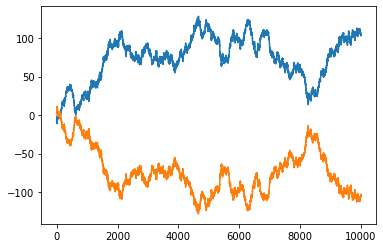

In [311]:
correlated_BM(steps = 10000, rho = -1)

In [498]:
def heston(seed = 0, T = 1, N = 2000, S_0 = 100, V_0 = 0.5, mu = 1, theta = 4, omega = 0.02, xi = 0.9, rho = 0.9, paths = 3):
    np.random.seed(seed)
    dt = T/N
    size = (paths, N)
    
    S = np.zeros(size)    
    S[:, 0] = S_0
    
    V = np.zeros(size)
    V[:, 0] = V_0
    

    
    for i in range(1, N):
        W = np.random.multivariate_normal(np.array([0,0]), np.array([[1, rho], [rho, 1]]), size = paths) * np.sqrt(dt)
        
        S[:, i] = S[:, i-1] * np.exp( (mu - 0.5*V[:, i-1]) * dt + np.sqrt(V[:, i-1]) * np.sqrt(dt) * W[:, 0] )
        V[:, i] = np.abs(V[:, i-1] + theta * (omega - V[:, i-1]) * dt + xi * np.sqrt(V[:, i-1]) * W[:, 1])
        
    time = np.arange(0, T+dt, dt)
    
    
#     plt.plot(time, S)

    return S

In [404]:
def bs_call(S = 100, K = 70, T = 1, r = 0.05, sigma = 0.7):
    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [406]:
def bs_put(S = 100, K = 70, T = 1, r = 0.05, sigma = 0.7):
    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    return  K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [407]:
def implied_volatility(option_price = 70, S = 100, K = 80, T = 1 , r = 0.05, call = 1):
    if call == 1:
        def co(sigma):
            return abs(bs_call(S, K, T, r, sigma) - option_price)
        sigma_star = minimize_scalar(co, bounds=(0.01,6), method='bounded')
        return sigma_star.x
#         bounds = (0.0001, 10), method = "bounded"
        
    elif call == 0: 
        def po(sigma):
            return abs(bs_put(S, K, T, r, sigma) - option_price)
        sigma_star = minimize_scalar(po, bounds=(0.01,6), method='bounded')
        return sigma_star.x


In [547]:
def smile(lower = 1, upper = 200, step = 2, T = 1, N = 200, S_0 = 100, V_0 = 0.02, mu = 0.02, theta = 4, omega = 0.02,
          xi = 0.9, rho = 0.9, r = 0.05, paths = 100):
    
    np.random.seed(0)
    strikes = np.arange(lower, upper, step)
    calls = []
    puts = []
    
    
    prices = heston(T = T, N = N, S_0 = S_0, V_0 = V_0, mu = mu, 
                    theta = theta, omega = omega, xi = xi, rho = rho, paths = paths)[:, -1]

    for k in strikes:

        calls.append(np.mean(np.maximum(prices - k , 0)) * np.exp(-r * T))
        puts.append(np.mean(np.maximum(k - prices, 0)) * np.exp(-r * T))
        
        

    # print(vals)
    call_ivs = [implied_volatility(option_price = C, S = S_0, K = k, T = T, r = r , call = 1) for C, k in zip(calls, strikes)]
    put_ivs = [implied_volatility(option_price = P, S = S_0, K = k, T = T, r = r, call = 0) for P, k in zip(puts, strikes)]
    # print(ivs)
    

    plt.plot(strikes, call_ivs, label = "IV Calls")
    plt.plot(strikes, put_ivs, label = "IV Puts")
    plt.legend()
    plt.axvline(S_0, color='black',linestyle='--', label='Spot Price')
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title('Implied Volatility Smile from Heston Model')

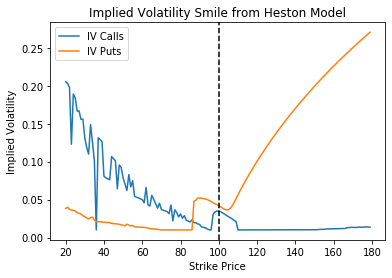

In [560]:
smile(lower = 20, upper = 180, step = 1, T = 1, N = 252, S_0 = 100, V_0 = 0.5, mu = 0.1125, theta = 3, omega = 0.04,
          xi = 0.9, rho = 0.7, r = 0.02, paths = 1000)